# Training a Neural Network Splitting the Data

This notebook provides you with a complete code example that loads the data contained in the `data_reg_2d_nonlinear.csv` file and splits them into a training, a validation, and a test set. Then, it trains a two-layer neural network using the training data, while monitoring the training and validation MSE. Finally, it uses the trained network to predict the values of the test data (test hold-out dataset) in the `data_reg_2d_linear_test.csv` file.

## Loading and Splitting the Data

In [1]:
from loader import load_data

(x, y_gt) = load_data(filename="data_reg_2d_nonlinear.csv")

In [2]:
from numpy import delete, split
from numpy.random import choice

num_samples = len(x)
split = .70

num_samples_train = int(split * num_samples)
train_idx = choice(num_samples, num_samples_train, replace=False)

x_train = x[train_idx]  # Train inputs.
y_gt_train = y_gt[train_idx]  # Train ground truths.

x_val = delete(x, train_idx, axis=0)  # Validation inputs.
y_gt_val = delete(y_gt, train_idx, axis=0)  # Validation ground truths.

## Implementing a Dense Neural Network

Implement the sigmoidal function

In [3]:
from numpy import exp

def sigmoid(x):
    """Sigmoid function."""
    return 1 / (1 + exp(-x))

... implement a function to define the neural network ...

In [4]:
def dnn2_reg(wa, wb, x):
    """Two-layer dense neural network for classification."""
    return sigmoid(x @ wa) @ wb

... define the number of neurons of the first layer ...

In [5]:
num_neurons = 3

... randomly initialize its weights ...

In [6]:
from numpy.random import default_rng

rng = default_rng()
wa = rng.standard_normal(size=(2, num_neurons)) # Input weights layer 1.
wb = rng.standard_normal(size=(num_neurons, 1)) # Input weights layer 2.

... obtain its predictions for the training and validation datasets ...

In [7]:
y_p_train = dnn2_reg(wa, wb, x_train)
y_p_val = dnn2_reg(wa, wb, x_val)

... and plot its predictions for the training dataset ...

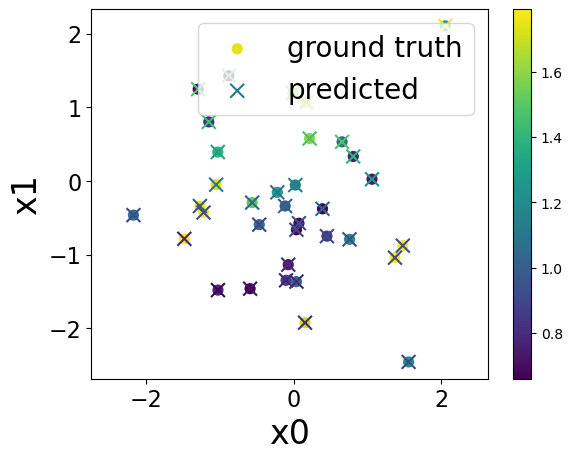

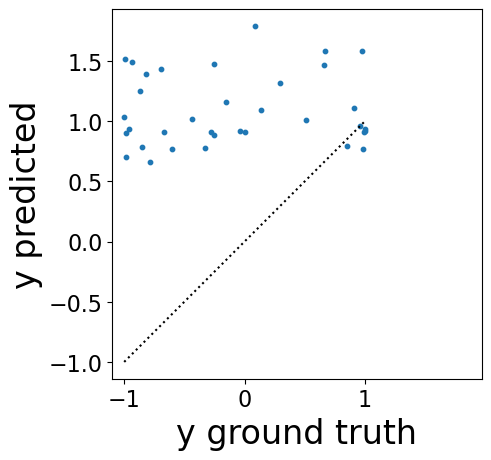

In [8]:
from plotting import plot_pred_2d, plot_pred_vs_gt

plot_pred_2d(x_train, y_gt_train, y_p=dnn2_reg(wa, wb, x_train))
plot_pred_vs_gt(y_gt_train, y_p=dnn2_reg(wa, wb, x_train))

... and for the validation dataset.

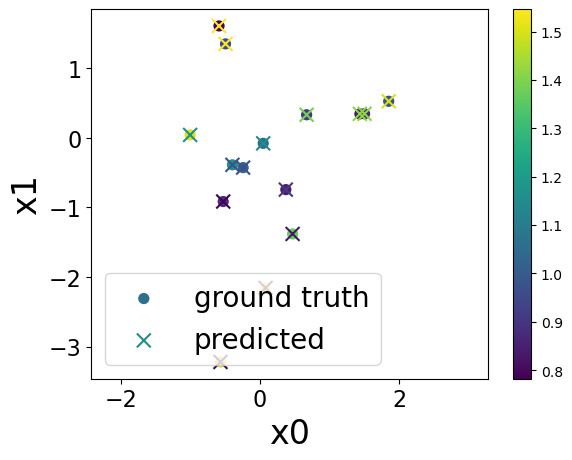

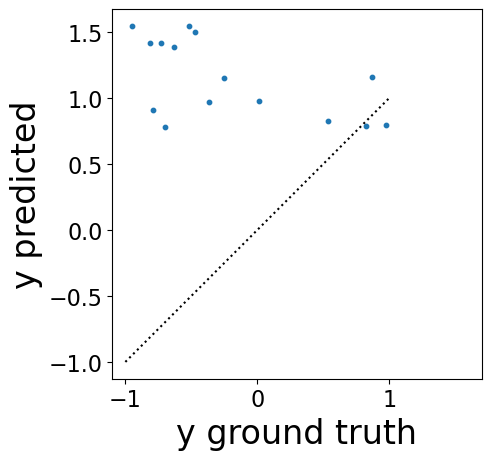

In [9]:
plot_pred_2d(x_val, y_gt_val, y_p=dnn2_reg(wa, wb, x_val))
plot_pred_vs_gt(y_gt_val, y_p=dnn2_reg(wa, wb, x_val))

## Training and Validating the Neural Network

Implement the first derivative of the sigmoid function ...

In [10]:
def d_sigmoid(x):
    """Derivative of sigmoid function."""
    return sigmoid(x) * (1 - sigmoid(x))

... implement the backpropagation algorithm with mini-batches ...

In [11]:
from numpy import mean, reshape, sum, transpose, zeros
from numpy.random import permutation

num_samnum_samples_trainples = len(x_train)
num_batches = 7
batch_size = int(num_samples / num_batches)
num_epochs = 10 ** 4
eta = .1 # Learning rate.

mse_train = zeros((num_epochs,))
mse_val = zeros((num_epochs,))

for epoch in range(num_epochs):
    # Permute samples.
    permuted_order_samples = permutation(num_samples_train)
    x_permuted = x_train[permuted_order_samples]
    y_gt_permuted = y_gt_train[permuted_order_samples]

    for batch_start in range(0, num_samples_train, batch_size):
        dwa = zeros(wa.shape) # Initialize weight increments layer 1.
        dwb = zeros(wb.shape) # Initialize weight increments layer 2.
        
        for selected in range(batch_start, batch_start + batch_size):
            x_selected = reshape(x_permuted[selected], (1, -1))
            y_gt_selected = reshape(y_gt_permuted[selected], (1, -1))
            
            # Detailed neural network calculation.
            x_selected_a = x_selected # Input layer 1.
            p_a = x_selected_a @ wa # Activation potential layer 1.
            y_selected_a = sigmoid(p_a) # Output layer 1.

            x_selected_b = y_selected_a # Input layer 2.
            p_b = x_selected_b @ wb # Activation potential layer 2.
            y_selected_b = p_b # Output neuron layer 2 (output neuron).

            y_p_selected = y_selected_b
    
            # Update weights.
            error = y_p_selected - y_gt_selected
    
            delta_b = error * 1
            dwb -= eta * delta_b * transpose(x_selected_b)

            delta_a = sum(wb * delta_b, axis=1) * d_sigmoid(p_a)
            dwa -= eta * delta_a * transpose(x_selected_a)
    
        wa += dwa / batch_size # Update weights layer 1.
        wb += dwb / batch_size # Update weights layer 2.
        
    y_p_train = dnn2_reg(wa, wb, x_train)
    mse_train[epoch] = mean((y_p_train - y_gt_train) ** 2)
    
    y_p_val = dnn2_reg(wa, wb, x_val)
    mse_val[epoch] = mean((y_p_val - y_gt_val) ** 2)
    
    print(f"{epoch} MSE train={mse_train[epoch]:.4f} val={mse_val[epoch]:.4f}")

0 MSE train=1.2356 val=1.5793
1 MSE train=0.8931 val=1.1083
2 MSE train=0.7349 val=0.8735
3 MSE train=0.6493 val=0.7338
4 MSE train=0.6117 val=0.6638
5 MSE train=0.5895 val=0.6167
6 MSE train=0.5759 val=0.5833
7 MSE train=0.5683 val=0.5622
8 MSE train=0.5633 val=0.5478
9 MSE train=0.5591 val=0.5342
10 MSE train=0.5563 val=0.5272
11 MSE train=0.5535 val=0.5191
12 MSE train=0.5509 val=0.5104
13 MSE train=0.5487 val=0.5023
14 MSE train=0.5471 val=0.4986
15 MSE train=0.5454 val=0.4917
16 MSE train=0.5440 val=0.4862
17 MSE train=0.5427 val=0.4805
18 MSE train=0.5417 val=0.4766
19 MSE train=0.5407 val=0.4738
20 MSE train=0.5399 val=0.4729
21 MSE train=0.5391 val=0.4696
22 MSE train=0.5384 val=0.4661
23 MSE train=0.5378 val=0.4631
24 MSE train=0.5372 val=0.4614
25 MSE train=0.5367 val=0.4584
26 MSE train=0.5363 val=0.4567
27 MSE train=0.5359 val=0.4559
28 MSE train=0.5356 val=0.4530
29 MSE train=0.5353 val=0.4510
30 MSE train=0.5350 val=0.4504
31 MSE train=0.5348 val=0.4489
32 MSE train=0.534

... and plot the training metrics (which often feature overfitting) ...

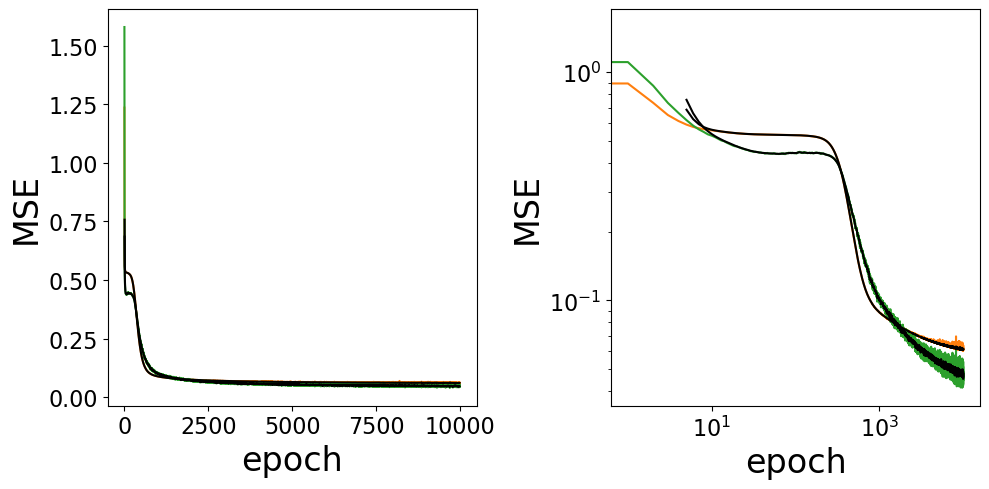

In [12]:
from plotting import plot_mse_train_vs_val

plot_mse_train_vs_val(mse_train, mse_val)

... and the predictions for the training set ...

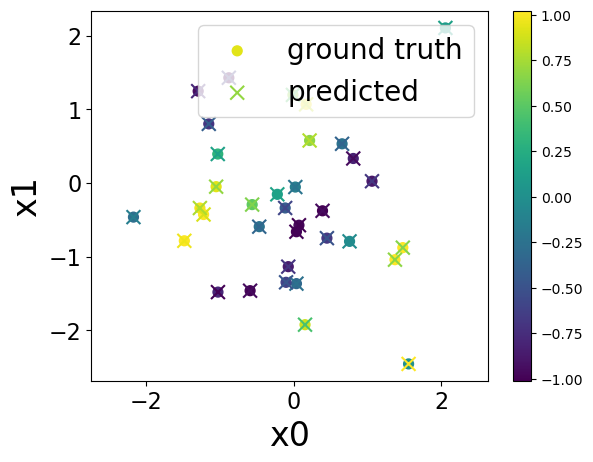

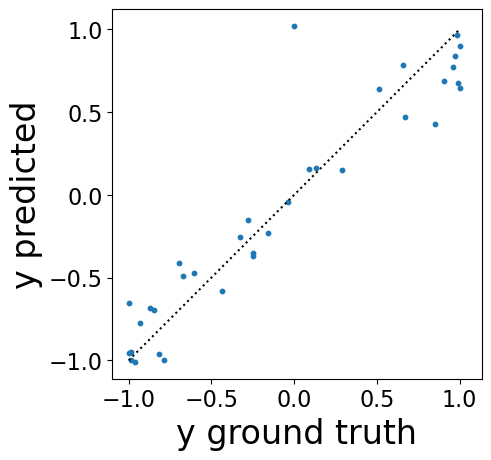

In [13]:
plot_pred_2d(x_train, y_gt_train, y_p=dnn2_reg(wa, wb, x_train))
plot_pred_vs_gt(y_gt_train, y_p=dnn2_reg(wa, wb, x_train))

... the predictions for the validation set ...

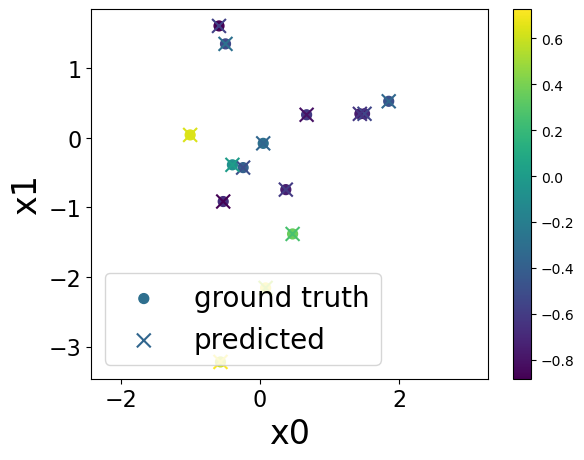

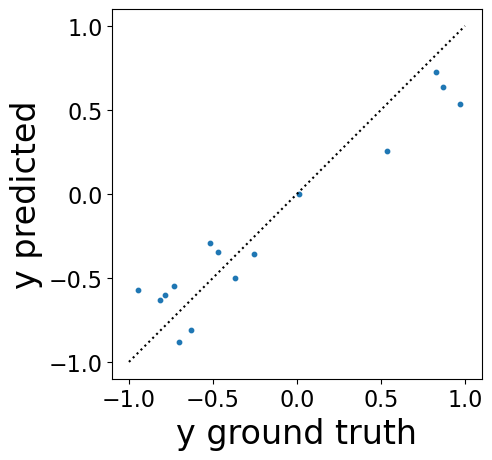

In [14]:
plot_pred_2d(x_val, y_gt_val, y_p=dnn2_reg(wa, wb, x_val))
plot_pred_vs_gt(y_gt_val, y_p=dnn2_reg(wa, wb, x_val))

... and the predictions for the test set.

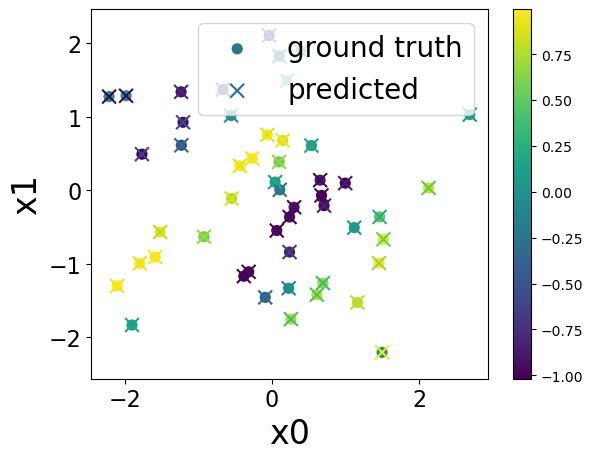

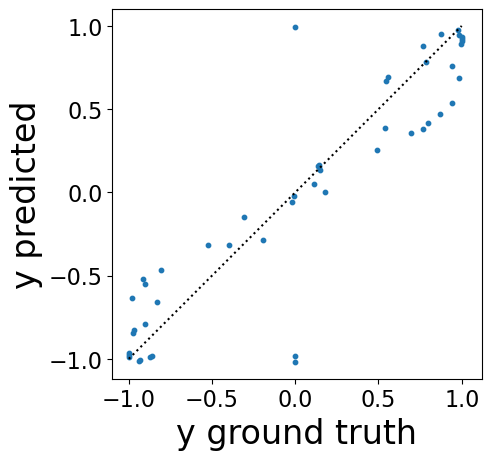

In [15]:
(x_test, y_gt_test) = load_data(filename="data_reg_2d_nonlinear_test.csv")

plot_pred_2d(x_test, y_gt_test, y_p=dnn2_reg(wa, wb, x_test))
plot_pred_vs_gt(y_gt_test, y_p=dnn2_reg(wa, wb, x_test))